In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset Creation

In [32]:
from preprocess import make_dataset
import pandas as pd
import numpy as np
import os

# Extract all the midi files 

midi_files = []

for path, subdirs, files in os.walk(r'./maestro-v3.0.0/'):
    for name in files:
        if (name.endswith('.midi') or name.endswith('.mid')):
            midi_files.append(os.path.join(path, name))

In [33]:
TEST_FILE = r'./maestro-v3.0.0/2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi'


In [34]:
df = make_dataset(midi_files, file_name="datasets/maestro.csv")


Processing Files...: 100%|██████████| 1276/1276 [13:02<00:00,  1.63files/s, ./maestro-v3.0.0/2018\MIDI-Unprocessed_Schubert7-9_MID--AUDIO_16_R2_2018_wav.midi]                          


In [38]:
import pretty_midi
from models.data_split import NUM_MIDI_NOTES, VOCABULARY
import matplotlib.pyplot as plt
import librosa

In [39]:
toks = df.iloc[0]['notes']
durations = df.iloc[0]['durations']
times = df.iloc[0]["times"]
velocities = df.iloc[0]['velocities']

In [48]:
print(toks)
print(durations)
print(times)

[128, 129, 71, 130, 129, 55, 130, 129, 71, 130, 129, 59, 130, 129, 62, 130, 129, 72, 130, 129, 67, 130, 129, 74, 130, 129, 57, 129, 72, 130, 129, 74, 130, 129, 72, 130, 129, 67, 130, 129, 66, 130, 129, 71, 130, 129, 64, 130, 129, 72, 130, 129, 74, 130, 129, 59, 130, 129, 62, 130, 129, 66, 130, 129, 67, 130, 129, 71, 130, 129, 74, 130, 129, 78, 130, 129, 59, 130, 129, 79, 130, 129, 76, 130, 129, 60, 130, 129, 79, 130, 129, 74, 130, 129, 59, 130, 129, 79, 130, 129, 72, 130, 129, 57, 130, 129, 71, 130, 129, 72, 130, 129, 66, 130, 129, 81, 130, 129, 72, 130, 129, 55, 130, 129, 71, 130, 129, 69, 130, 129, 59, 130, 129, 67, 130, 129, 71, 130, 129, 62, 130, 129, 54, 130, 129, 67, 130, 129, 52, 130, 129, 50, 130, 129, 49, 130, 129, 64, 130, 129, 76, 130, 129, 69, 130, 129, 52, 130, 129, 76, 130, 129, 57, 130, 129, 67, 130, 129, 66, 130, 129, 49, 130, 129, 67, 130, 129, 76, 130, 129, 67, 130, 129, 50, 130, 129, 66, 130, 129, 64, 130, 129, 54, 130, 129, 62, 130, 129, 64, 130, 129, 57, 130, 129, 

In [51]:
midi_file = pretty_midi.PrettyMIDI(resolution=480)

piano = pretty_midi.Instrument(0)

time = 0
duration = 0
tpq = midi_file.resolution

v_itr = 0
d_itr = 0
t_itr = 0

for i, tok in enumerate(toks):
    if tok < NUM_MIDI_NOTES:
        print(time / tpq, tok, (time + duration) / tpq)
        note = pretty_midi.Note(velocity=velocities[v_itr], pitch=tok, start=time / tpq, end=(time + duration) / tpq)
        v_itr += 1
        piano.notes.append(note)
    elif tok == VOCABULARY['EOS']:
        break # Stop Generating for EOS
    elif tok == VOCABULARY['SEP']:
        duration = durations[d_itr]
        d_itr += 1
    elif tok == VOCABULARY['BEAT']:
        time += times[t_itr]
        t_itr += 1


midi_file.instruments.append(piano)

midi_file.write("test.mid")

0.0 71 0.0
0.0 55 0.09687499999999982
1.0927083333333334 71 1.3104166666666666
1.2791666666666663 59 1.7843749999999998
1.2885416666666667 62 1.4562499999999998
1.4635416666666667 72 1.5833333333333333
1.6333333333333333 67 1.675
1.7864583333333333 74 1.9833333333333336
1.803125 57 1.9177083333333331
1.803125 72 2.3427083333333334
1.9833333333333336 74 2.0520833333333335
2.0375 72 2.121875
2.097916666666667 67 2.46875
2.1489583333333333 66 2.2572916666666667
2.171875 71 2.353125
2.328125 64 2.394791666666667
2.5229166666666667 72 2.7281250000000004
2.558333333333333 74 2.641666666666666
2.5906250000000006 59 3.3593750000000004
2.679166666666667 62 3.3864583333333345
2.7125000000000004 66 2.9385416666666666
2.887500000000001 67 3.080208333333334
3.0802083333333337 71 5.158333333333333
3.2500000000000004 74 3.3989583333333337
3.4531250000000004 78 3.639583333333334
3.619791666666667 59 3.846875000000001
3.7989583333333337 79 3.9583333333333344
3.807291666666667 76 4.014583333333333
3.992

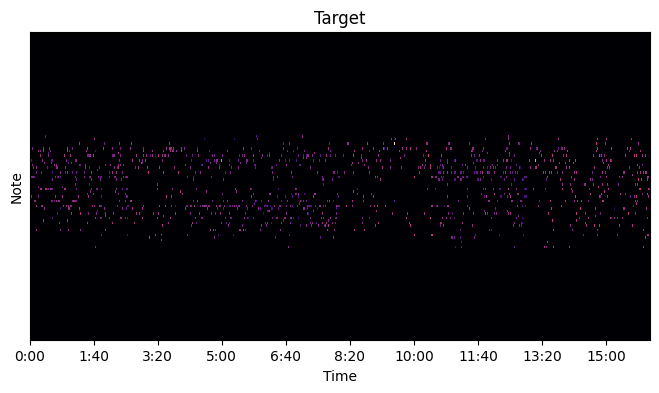

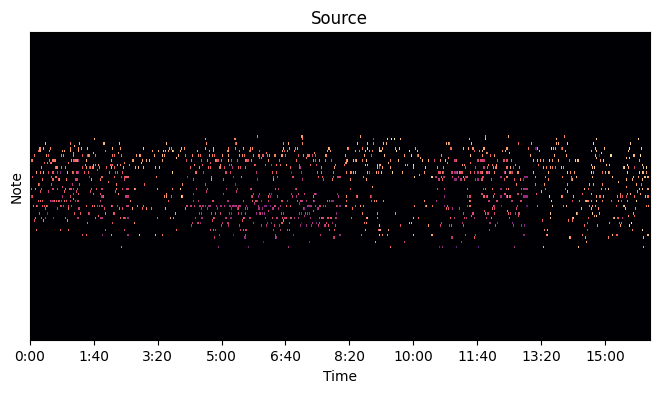

480


In [41]:
fs = 40

plt.figure(figsize=(8, 4))
plt.title("Target")
librosa.display.specshow(midi_file.get_piano_roll(fs),
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note')
plt.show()

target = pretty_midi.PrettyMIDI(TEST_FILE)
plt.figure(figsize=(8, 4))
plt.title("Source")
librosa.display.specshow(target.get_piano_roll(fs),
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note')
plt.show()

print(target.resolution)

# Dataset Analysis

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv("datasets/maestro.csv")

In [8]:
lengths = df.notes.apply(lambda x: len(x))

(array([ 1.,  5.,  5.,  8., 16., 24., 46., 48., 35., 42., 61., 56., 37.,
        47., 23., 40., 33., 19., 17., 28., 24., 26., 17., 26., 28., 24.,
        12., 16., 22., 33., 37., 23., 22., 23.,  6.,  9., 34., 26., 29.,
        20., 14., 10.,  5.,  8.,  3.,  5.,  5.,  5.,  9.,  7.,  6.,  1.,
         5.,  1.,  0.,  2.,  3.,  2.,  5.,  4.,  7.,  6.,  6.,  4.,  7.,
         7.,  4.,  1.,  3.,  1.,  5.,  1.,  4.,  0.,  0.,  0.,  1.,  2.,
         3.,  1.,  5.,  4.,  4.,  2.,  7.,  3.,  2.,  2.,  1.,  2.,  1.,
         4.,  1.,  4.,  2.,  2.,  7.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,
         2.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1162.      ,   2914.578125,   4667.15625 ,   6419.734375,
          8172.3125  ,   9924.890625,  11677.46875 ,  13430.046875,
         15182.625   ,  16935.203125,  18687.78125 ,  20440.359375,
         22192.9375  ,  23945.515625,  25698.09375 ,  27450.671875,
      

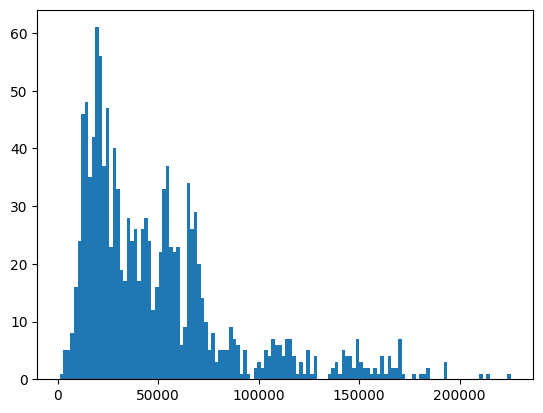

In [9]:
plt.hist(lengths, bins=128)

In [49]:
df['notes'] = df.notes.apply(lambda x: [int(y) for y in str(x).removeprefix('[').removesuffix(']').split(' ') if y.isnumeric()])
df['velocities'] = df.velocities.apply(lambda x: [int(y) for y in str(x).removeprefix('[').removesuffix(']').split(' ') if y.isnumeric()])
df['times'] = df.times.apply(lambda x: [float(y) for y in str(x).removeprefix('[').removesuffix(']').split(' ') if y.replace('.', '').replace('e+', '').replace('e-','').isnumeric()])
df['durations'] = df.durations.apply(lambda x: [float(y) for y in str(x).removeprefix('[').removesuffix(']').split(' ') if y.replace('.', '').replace('e+', '').replace('e-','').isnumeric()])

In [50]:
print(df.iloc[11088])

plt.plot(df['times'][11088])

IndexError: single positional indexer is out-of-bounds

In [ ]:
note_bins = [0 for i in range(0, 200)]
velocity_bins = [0 for i in range(0, 128)]
duration_means = []
duration_std = []

time_means = []
time_std = []

for i in range(0, len(df['notes'])):
    for x in df['notes'][i]:
        note_bins[x] += 1

    for x in df['velocities'][i]:
        velocity_bins[x] += 1
    
    duration_means.append(np.mean(df['durations'][i]))
    duration_std.append(np.std(df['durations'][i]))

    time_means.append(np.mean(df['times'][i]))
    time_std.append(np.std(df['times'][i]))


In [ ]:
plt.plot(note_bins)
plt.xlim((0, 127))
plt.ylim(0, max(note_bins[0:128]))
plt.show()

In [ ]:
p = duration_means
q = duration_std
p[np.argmax(duration_means)] = 0
q[np.argmax(duration_std)] = 0

plt.scatter(p, q)

In [ ]:
p = time_means
q = time_std
p[np.argmax(time_means)] = 0
p[np.argmax(time_means)] = 0

q[np.argmax(time_std)] = 0
q[np.argmax(time_std)] = 0

plt.scatter(p,q)

In [ ]:
plt.plot(velocity_bins)
plt.xlim((0, 127))
plt.ylim(0, max(velocity_bins[0:128]))
plt.show()

In [ ]:
# Analysis specific to duration.
# We want to determine if we can quantize it some Gaussian noise

vals = []
losses_mean = []
losses_std = []
D = 32

for D in [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    L = []
    for track in df['durations']:
        p = np.array(track)
        l = D * p - np.trunc(D * p) 

        L.append(np.mean(l))
    L = np.array(L)
    losses_mean.append(np.mean(L))
    losses_std.append(np.std(L))

        

In [ ]:
plt.plot(losses_mean)
plt.plot(losses_std)

In [1]:
import pretty_midi as pm

In [13]:
FILE = r'Ode to Joy from the 9th Symphony.mid'
midi = pm.PrettyMIDI(FILE)

In [74]:
import math 
midi.remove_invalid_notes()

resolution = midi.resolution
qpt = 1.0 / resolution

for instrument in midi.instruments:
    bundles = []

    i = 0

    notes_list = sorted(instrument.notes, key = lambda x: x.start) 

    while i < len(notes_list):
        bundle = []  

        bnote :pm.Note = None   
        while i < len(notes_list): 
            note : pm.Note = notes_list[i]

            if len(bundle) == 0:
                bundle.append(note)
                bnote = note 
                i = i + 1
            elif math.isclose(midi.time_to_tick(note.start), midi.time_to_tick(bnote.start), rel_tol=1e-5) and \
                math.isclose(midi.time_to_tick(note.end), midi.time_to_tick(bnote.end), rel_tol=1e-5):
                bundle.append(note)
                i = i + 1
            else: 
                bundles.append(bundle)
                break
        
        if i >= len(instrument.notes):
            bundles.append(bundle)

bundles = sorted(bundles, key=lambda x: x[0].start)

count = 0
for x in bundles:
    print(x)
    count += len(x)

print(count, len(midi.instruments[0].notes))


[Note(start=0.416666, end=0.624131, pitch=69, velocity=127), Note(start=0.416666, end=0.624131, pitch=57, velocity=127), Note(start=0.416666, end=0.624131, pitch=62, velocity=127), Note(start=0.416666, end=0.624131, pitch=65, velocity=127)]
[Note(start=0.416666, end=0.936630, pitch=82, velocity=127), Note(start=0.416666, end=0.936630, pitch=70, velocity=127), Note(start=0.416666, end=0.936630, pitch=74, velocity=127), Note(start=0.416666, end=0.936630, pitch=77, velocity=127)]
[Note(start=0.624999, end=0.676214, pitch=45, velocity=127), Note(start=0.624999, end=0.676214, pitch=41, velocity=127)]
[Note(start=0.677082, end=0.728297, pitch=53, velocity=127)]
[Note(start=0.729165, end=0.780381, pitch=41, velocity=127), Note(start=0.729165, end=0.780381, pitch=45, velocity=127)]
[Note(start=0.781249, end=0.832464, pitch=53, velocity=127)]
[Note(start=0.833332, end=0.884547, pitch=45, velocity=127), Note(start=0.833332, end=0.884547, pitch=41, velocity=127)]
[Note(start=0.885415, end=0.93663